## This notebook is for Task 2 only

Improvements Task 2:

- Refer to one of the picture sent of whatsapp
- Could split chart into two/three views:
    + one is all wages, ranging from mininum to max
    + other is some wages, ranging from minimum to user-selected end point
    + And above two stack together vertically?
- Violin plots can zoom by changing the ranges
- Add another two more charts that are "weighted" by attribute 1 (one chart), attribute 2 (another chart), and these two could have selection filters on the wages violin plot
- Consider dropdown filter by region/country

In [1]:
# imports
import altair as alt
import pandas as pd
import sys
import os
# altair specific
alt.data_transformers.disable_max_rows()
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')
# adds parent directory to this notebook, so it could use relative import
sys.path.append(os.path.dirname(os.getcwd()))

# user defined modules
from src.helpers import preprocessing


In [3]:
# helper function
def get_data(data_path, preprocess=False):
    data = pd.read_csv(data_path)
    if preprocess is True:
        fifa_subset = preprocessing(data)
        # store to data
        data = fifa_subset
    return data

In [5]:
# read data here
data_path = "../data/player_raw_data.csv"
# this is raw data
fifa = get_data(data_path)
# this is processed for Task 5 specific
subset = get_data(data_path, preprocess=True)

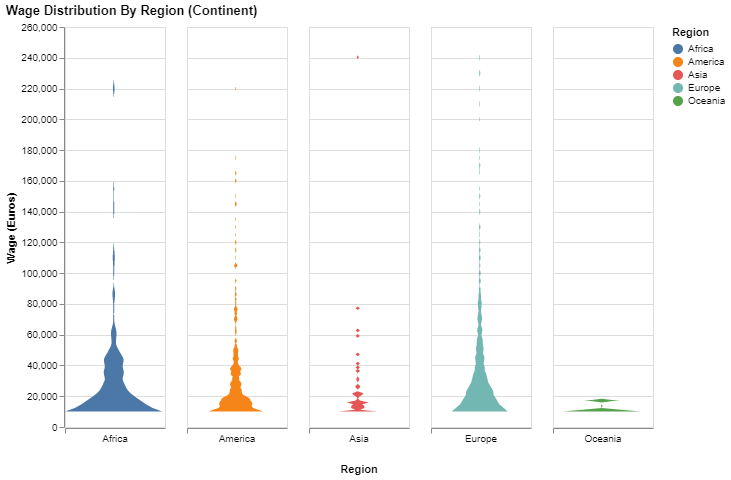

In [82]:
# 2. Discover distribution of wages by continent/country. Include weighted by skill/some attributes. 
# Those that do better would be paying their players more high std, should give pretty spread distributions
# basic_hist = alt.Chart(fifa_subset).mark_bar().encode(
#     x = alt.X("wage", scale=alt.Scale(domainMin=0, domainMax=500_000), bin=alt.Bin(maxbins=50)),
#     y = alt.Y("count(wage)")
# )

# using violet plot could be misleading, since max is 450_000, min is like 500

# Click on the specfic Region
click = alt.selection_single(
    #empty='none',
    fields=['region'],
    bind='legend'
)

wage_violin = alt.Chart(subset).transform_density(
    'wage',
    extent=[10_000, 250_000],
    as_=['wage', 'density'],
    groupby=['region']
).mark_area(orient='horizontal').encode(
    y=alt.Y('wage:Q', title="Wage (Euros)"),
    color=alt.Color('region:N', title="Region"),
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True),
    ),
    column=alt.Column(
        'region:N',
        title="Region",
        header=alt.Header(titleOrient='bottom', labelOrient='bottom', labelPadding=0)
    )
).properties(
    width=100,
    height=400,
    title="Wage Distribution By Region (Continent)"
).add_selection(click) #.configure_facet(
#    spacing=0
#).configure_view(
#    stroke=None
#)

wage_violin

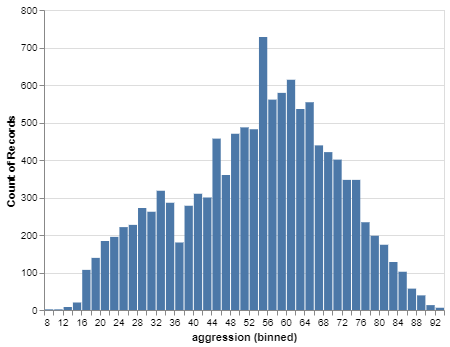

In [66]:
# define the dropdown selection object
# first three are categories
attributes = subset.columns.tolist()[3:]

# This is still useless now
# selection = alt.selection_single(
#     name="Select",
#     fields=["x"],
#     encodings=["x"],
#     init={"attribute": "aggression"},
#     bind={"attribute": alt.binding_select(options=attributes),
#          }
# )

# base histogram, add selector later
attr_hist = alt.Chart(subset).mark_bar().encode(
    x = alt.X("aggression:Q", bin=alt.Bin(maxbins=50)),
    y='count()'
)


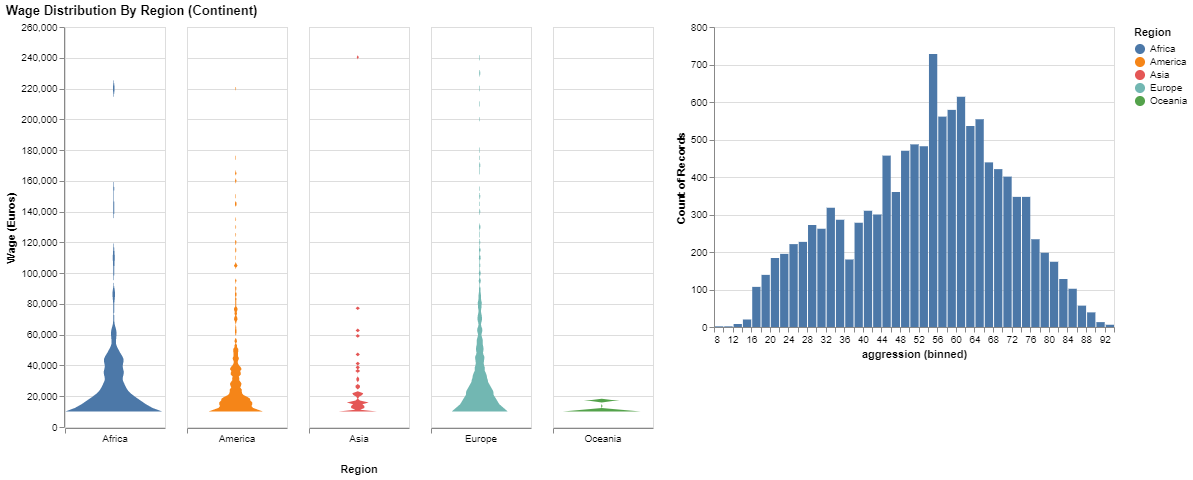

In [71]:
wage_violin | attr_hist